This add normalization, best result so far
Also add suffling to the training data

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [9]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [10]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [11]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [12]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [13]:
def prepare_structure_data(df):
    """Enhanced feature preparation focusing on important features"""
    features_list = []
    middle_pos = 16  # Center position
    
    # Helper function for normalization
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Most important features (importance > 0.04) - using ±0 window
    important_features = [
        'bfactor',
        'distance_to_center',
        'sasa',
        'omega',
        'domain_position'
    ]
    
    for feature in important_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        # Take only the center position
        center_values = feature_arrays[:, middle_pos]
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
        features_list.append(scaled_values)
    
    # 2. Secondary important features (0.03 < importance < 0.04)
    secondary_features = [
        'chi1', 'chi2', 'chi3', 'chi4',
        'curvature', 'psi', 'phi', 'tau',
        'packing_density', 'local_hydrophobicity'
    ]
    
    for feature in secondary_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        center_values = feature_arrays[:, middle_pos]
        if feature in ['phi', 'psi', 'omega', 'tau']:
            # Angle features get sin/cos encoding
            angle_features = normalize_angles(center_values)
            features_list.append(angle_features)
        else:
            scaler = RobustScaler()
            scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
            features_list.append(scaled_values)
    
    # 3. Special case: hydrophobicity with ±1 window
    hydro_arrays = np.array([np.array(eval(x)) for x in df['hydrophobicity']])
    hydro_window = hydro_arrays[:, middle_pos-1:middle_pos+2]  # ±1 window
    scaler = RobustScaler()
    hydro_scaled = scaler.fit_transform(hydro_window.reshape(-1, 1)).reshape(len(hydro_arrays), 3)
    features_list.append(hydro_scaled)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    # Add a dimension for the "sequence" length (1 for center position)
    features = features.reshape(features.shape[0], 1, -1)
    
    return features

In [14]:
def create_combined_model_with_prot_t5(seq_length=33, struct_features=None, struct_window=0):
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # Structure track
    struct_input = tf.keras.layers.Input(shape=(1, struct_features), name='structure_input')
    x_struct = struct_input
    struct_dense_size = min(struct_features * 2, 128)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.4)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu',
                                   kernel_regularizer=regularizer)(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.4)(x_struct)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(3, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 2:3])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, struct_input, prot_t5_input], outputs=outputs)
    
    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1]),
                'prot_t5': float(normalized[2])
            }
        return {'sequence': 0.33, 'structure': 0.33, 'prot_t5': 0.34}

    model.get_track_weights = get_track_weights
    return model

In [15]:
def train_and_evaluate():
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare other data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    X_train_struct = prepare_structure_data(train_df_aligned)
    X_test_struct = prepare_structure_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Shuffle training data
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train_seq = X_train_seq[shuffle_idx]
    X_train_struct = X_train_struct[shuffle_idx]
    X_train_prot_t5 = X_train_prot_t5[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Shuffle test data
    shuffle_idx_test = np.random.RandomState(42).permutation(len(y_test))
    X_test_seq = X_test_seq[shuffle_idx_test]
    X_test_struct = X_test_struct[shuffle_idx_test]
    X_test_prot_t5 = X_test_prot_t5[shuffle_idx_test]
    y_test = y_test[shuffle_idx_test]
    
    # Print class distribution after shuffling
    print("\nTraining set distribution (after shuffling):")
    print(pd.Series(y_train).value_counts())
    print("\nTest set distribution (after shuffling):")
    print(pd.Series(y_test).value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model_with_prot_t5(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=0
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4260
Name: count, dtype: int64

Test set distribution (after shuffling):
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8852, 33)
X_train_struct: (8852, 1, 21)
X_train_prot_t5: (8852, 1024)
X_test_seq: (2737, 33)
X_test_struct: (2737, 1, 21)
X_test_prot_t5: (2737, 1024)
y_train: (8852,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-11 22:26:46.738875: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-11 22:26:46.738911: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 22:26:46.738924: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 22:26:46.739155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 22:26:46.739173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-11 22:26:48.452491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - accuracy: 0.5072 - loss: 8.3107 - val_accuracy: 0.5833 - val_loss: 5.7498 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.5476 - loss: 5.2072 - val_accuracy: 0.6313 - val_loss: 3.5032 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - accuracy: 0.6010 - loss: 3.1556 - val_accuracy: 0.6612 - val_loss: 2.1997 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - accuracy: 0.6552 - loss: 2.0167 - val_accuracy: 0.6996 - val_loss: 1.5072 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.6821 - loss: 1.4185 - val_accuracy: 0.6815 - val_loss: 1.1733 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.7064 - loss: 1.1167 - val_accuracy: 0.7233 - val_loss: 1.0118 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.7091 - loss:

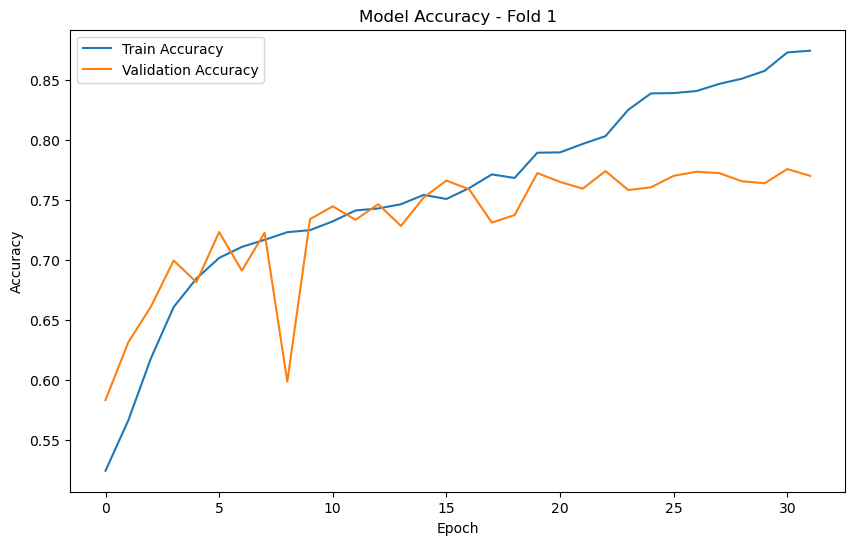

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 1 Results:
Accuracy: 0.7736
Balanced Accuracy: 0.7721
MCC: 0.5464
Sensitivity: 0.8109
Specificity: 0.7333

Learned track weights for fold 1:
Sequence weight: 0.4022
Structure weight: 0.2701
ProtT5 weight: 0.3277

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.5237 - loss: 8.1308 - val_accuracy: 0.5528 - val_loss: 5.4084 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.5472 - loss: 4.8034 - val_accuracy: 0.5963 - val_loss: 3.1289 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.6028 - loss: 2.7893 - val_accuracy: 0.6228 - val_loss: 1.9395 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.6419 - loss: 1.7710 - val_accuracy: 0.6685 - val_loss: 1.3862 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.6695 - loss: 1.3146 - val_accuracy: 0.6781 - val_loss: 1.1252 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.6973 - loss: 1.0757 - val_accuracy: 0.6940 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.7

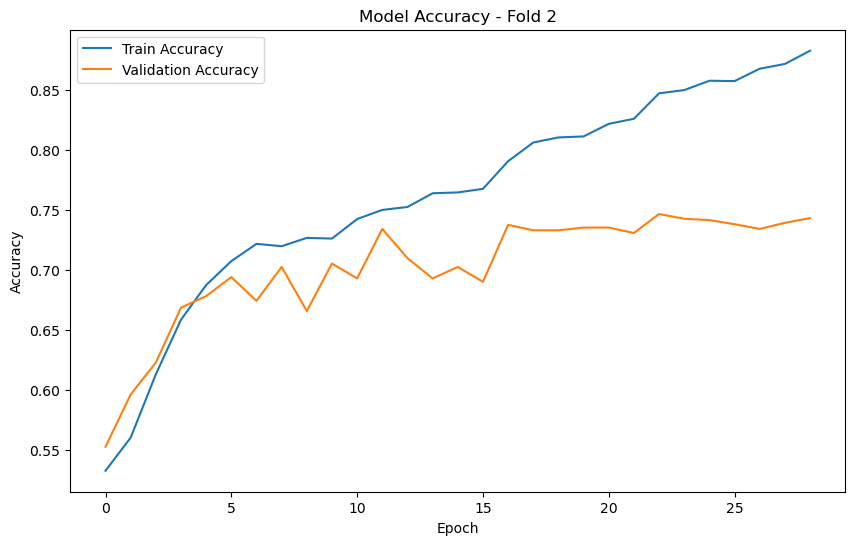

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 2 Results:
Accuracy: 0.7425
Balanced Accuracy: 0.7413
MCC: 0.4854
Sensitivity: 0.7907
Specificity: 0.6918

Learned track weights for fold 2:
Sequence weight: 0.4345
Structure weight: 0.2389
ProtT5 weight: 0.3266

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.5283 - loss: 8.3679 - val_accuracy: 0.5395 - val_loss: 5.9310 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.5614 - loss: 5.3275 - val_accuracy: 0.6215 - val_loss: 3.6000 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.6154 - loss: 3.2251 - val_accuracy: 0.6277 - val_loss: 2.2563 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.6708 - loss: 2.0402 - val_accuracy: 0.6588 - val_loss: 1.5602 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.6941 - loss: 1.4404 - val_accuracy: 0.6960 - val_loss: 1.2020 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 127ms/step - accuracy: 0.7053 - loss: 1.1534 - val_accuracy: 0.6774 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.7

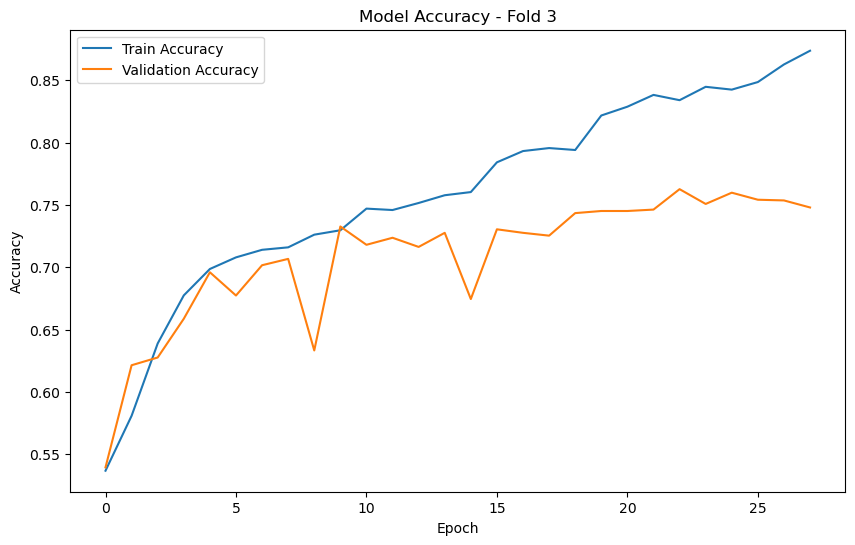

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 3 Results:
Accuracy: 0.7627
Balanced Accuracy: 0.7614
MCC: 0.5244
Sensitivity: 0.7935
Specificity: 0.7294

Learned track weights for fold 3:
Sequence weight: 0.4042
Structure weight: 0.2686
ProtT5 weight: 0.3272

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.5161 - loss: 8.4126 - val_accuracy: 0.5294 - val_loss: 6.0281 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.5423 - loss: 5.4442 - val_accuracy: 0.5927 - val_loss: 3.7352 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.5818 - loss: 3.3623 - val_accuracy: 0.6028 - val_loss: 2.3548 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.6420 - loss: 2.1219 - val_accuracy: 0.6599 - val_loss: 1.5997 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.6501 - loss: 1.5060 - val_accuracy: 0.6712 - val_loss: 1.2105 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 54s 243ms/step - accuracy: 0.6865 - loss: 1.1547 - val_accuracy: 0.7107 - val_loss: 1.0244 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 54s 244ms/step - accuracy: 0.6

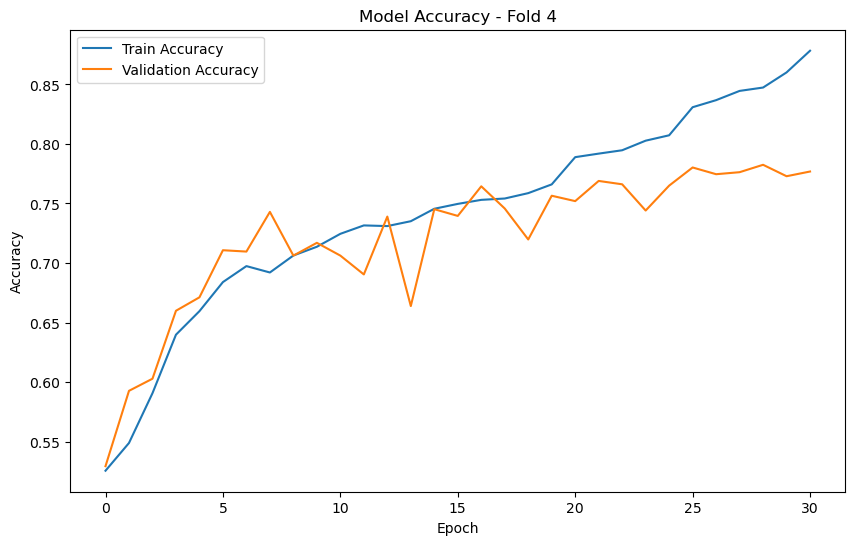

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

Fold 4 Results:
Accuracy: 0.7802
Balanced Accuracy: 0.7804
MCC: 0.5606
Sensitivity: 0.7747
Specificity: 0.7860

Learned track weights for fold 4:
Sequence weight: 0.4324
Structure weight: 0.2745
ProtT5 weight: 0.2932

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 99s 357ms/step - accuracy: 0.5144 - loss: 8.5169 - val_accuracy: 0.4966 - val_loss: 6.3086 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 60s 269ms/step - accuracy: 0.5714 - loss: 5.7549 - val_accuracy: 0.5181 - val_loss: 4.1526 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step - accuracy: 0.5939 - loss: 3.7438 - val_accuracy: 0.5780 - val_loss: 2.7255 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.6243 - loss: 2.4793 - val_accuracy: 0.5864 - val_loss: 1.8763 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.6552 - loss: 1.7304 - val_accuracy: 0.6723 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 71s 319ms/step - accuracy: 0.6903 - loss: 1.3112 - val_accuracy: 0.6294 - val_loss: 1.2069 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 79s 358ms/step - accuracy: 0.6

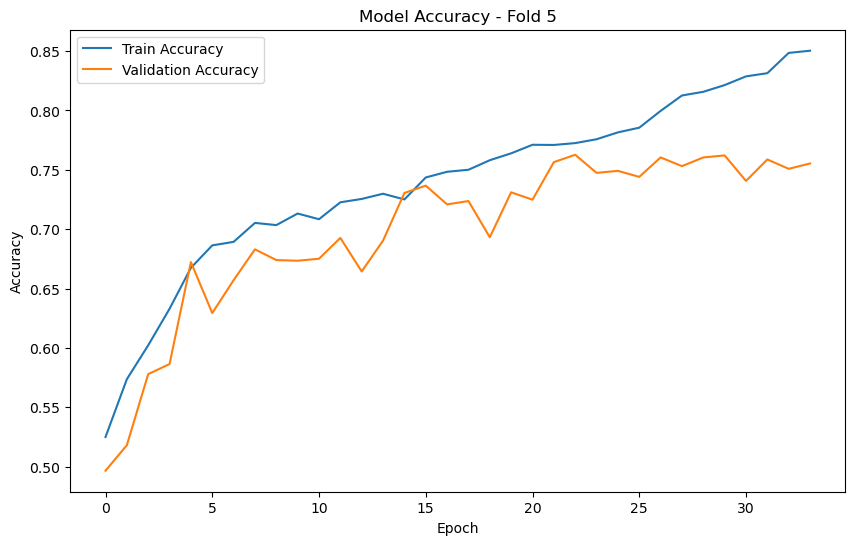

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Fold 5 Results:
Accuracy: 0.7605
Balanced Accuracy: 0.7609
MCC: 0.5211
Sensitivity: 0.7527
Specificity: 0.7691

Learned track weights for fold 5:
Sequence weight: 0.4726
Structure weight: 0.2570
ProtT5 weight: 0.2704

Average track weights across folds:
Sequence weight: 0.4292 ± 0.0256
Structure weight: 0.2618 ± 0.0128
ProtT5 weight: 0.3090 ± 0.0234

Average Cross-validation Results:
ACC: 0.7639 ± 0.0129
BALANCED_ACC: 0.7632 ± 0.0131
MCC: 0.5275 ± 0.0256
SN: 0.7845 ± 0.0196
SP: 0.7419 ± 0.0330

Final Test Set Results:
Accuracy: 0.7464
Balanced Accuracy: 0.7876
MCC: 0.3509
Sensitivity: 0.8375
Specificity: 0.7377
Confusion Matrix:
[[1842  655]
 [  39  201]]


In [16]:
if __name__ == "__main__":
    model = train_and_evaluate()